🔷 Paso 1: Cargar el Dataset y Análisis Exploratorio (EDA)

In [1]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("bank-full.csv", sep=';')

# Mostrar las primeras filas
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# New section

📊 Descripción general

In [3]:
print(f"Forma del dataset: {df.shape}\n")
print("Resumen de columnas y tipos de datos:")

df_summary = pd.DataFrame({
    'Columna': df.columns,
    'Tipo de dato': df.dtypes.values,
    'Valores únicos': [df[col].nunique() for col in df.columns],
    'Valores nulos': df.isnull().sum().values
})

print(df_summary.to_string(index=False))


Forma del dataset: (45211, 17)

Resumen de columnas y tipos de datos:
  Columna Tipo de dato  Valores únicos  Valores nulos
      age        int64              77              0
      job       object              12              0
  marital       object               3              0
education       object               4              0
  default       object               2              0
  balance        int64            7168              0
  housing       object               2              0
     loan       object               2              0
  contact       object               3              0
      day        int64              31              0
    month       object              12              0
 duration        int64            1573              0
 campaign        int64              48              0
    pdays        int64             559              0
 previous        int64              41              0
 poutcome       object               4              0
        y   

📈 Estadísticas descriptivas

In [4]:
# Estadísticas de variables numéricas
df.describe()

# Estadísticas de variables categóricas
df.describe(include='object')


,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


🔍 Distribución de la variable objetivo y

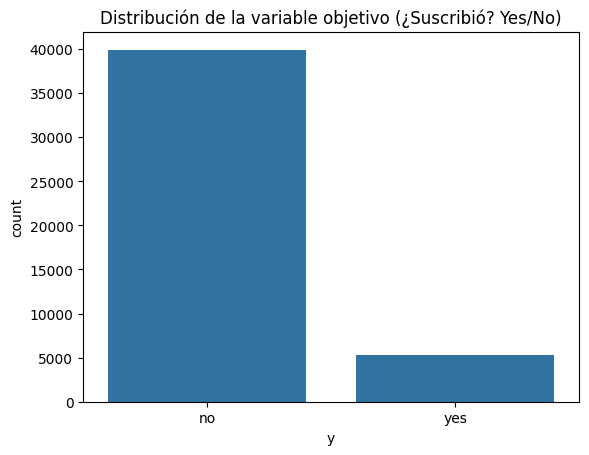

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='y')
plt.title('Distribución de la variable objetivo (¿Suscribió? Yes/No)')
plt.show()


📉 Correlación entre variables numéricas

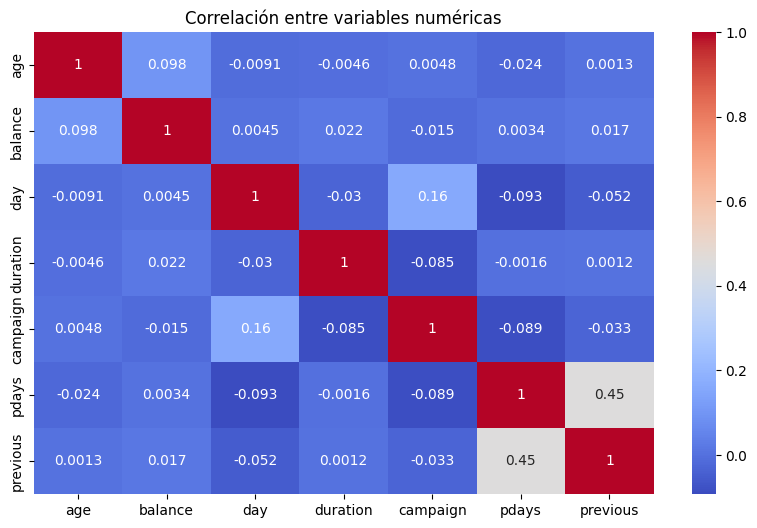

In [6]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()


🔷 Paso 2: Preprocesamiento y Transformación de los Datos
Este paso incluye:

Tratamiento de valores nulos o codificados como unknown

Codificación de variables categóricas

Transformación de variables tipo fecha (si las hubiera)

Separación de variables predictoras y target

✅ 2.1 Tratamiento de valores nulos
Este dataset no tiene NaN, pero usa unknown para representar datos faltantes.

In [7]:
# Contar valores 'unknown' por columna
unknowns = df.apply(lambda x: (x == 'unknown').sum())
unknowns[unknowns > 0]


job            288
education     1857
contact      13020
poutcome     36959
dtype: int64

no eliminar filas, sino agrupar unknown en una categoría explícita ("Desconocido").

🏷️ 2.2 Codificación de variables categóricas
Primero, identificamos las variables categóricas:

In [8]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('y')  # quitamos la variable objetivo
cat_cols


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

Usaremos One-Hot Encoding para estas variables. También codificamos el objetivo (y) como 0 y 1.

In [9]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Codificar la variable objetivo
df_encoded['y'] = df['y'].map({'no': 0, 'yes': 1})


🕒 2.3 Transformación de fechas
Este dataset no tiene fechas explícitas, pero month y day pueden tratarse como numéricas.

In [10]:
import calendar

# Mapear mes a número (ej: jan -> 1, feb -> 2, ...)
month_map = {month.lower(): index for index, month in enumerate(calendar.month_abbr) if month}

# Aplicar mapeo directamente sobre el DataFrame original
df['month_num'] = df['month'].str.lower().map(month_map)

# Luego puedes eliminar 'month' y seguir
df.drop(columns=['month'], inplace=True)

# Continuar con get_dummies()
df_encoded = pd.get_dummies(df, columns=[col for col in df.columns if df[col].dtype == 'object' and col != 'y'], drop_first=True)

# Codificar 'y'
df_encoded['y'] = df['y'].map({'no': 0, 'yes': 1})


In [11]:
# Ya es numérico, no hace falta convertir
df_encoded['day'] = df['day']


🔄 2.4 Separar X e y para modelado

In [12]:
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']


🔷 Paso 3: Entrenamiento de Modelos de Clasificación
Vamos a entrenar tres modelos diferentes:

Regresión Logística

Random Forest

XGBoost

✅ 3.1 Separación de entrenamiento y prueba

In [13]:
from sklearn.model_selection import train_test_split

# Variables predictoras y target
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

# 80% entrenamiento, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


📊 3.2 Función para evaluar modelos

In [14]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print(f"\n🔹 Resultados para: {nombre}")
    print("Entrenamiento:")
    print(f"  Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"  F1 Score: {f1_score(y_train, y_pred_train):.4f}")

    print("\nTest:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"  F1 Score: {f1_score(y_test, y_pred_test):.4f}")

    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred_test))
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred_test))


1️⃣ Regresión Logística

In [15]:
from sklearn.linear_model import LogisticRegression

modelo_lr = LogisticRegression(max_iter=1000)
evaluar_modelo("Regresión Logística", modelo_lr, X_train, X_test, y_train, y_test)



🔹 Resultados para: Regresión Logística
Entrenamiento:
  Accuracy: 0.8992
  F1 Score: 0.4076

Test:
  Accuracy: 0.8955
  F1 Score: 0.4119

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7952
           1       0.64      0.30      0.41      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043

Matriz de Confusión:
[[7767  185]
 [ 760  331]]


c:\Users\nichi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2️⃣ Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluar_modelo("Random Forest", modelo_rf, X_train, X_test, y_train, y_test)



🔹 Resultados para: Random Forest
Entrenamiento:
  Accuracy: 1.0000
  F1 Score: 1.0000

Test:
  Accuracy: 0.9012
  F1 Score: 0.4811

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7952
           1       0.66      0.38      0.48      1091

    accuracy                           0.90      9043
   macro avg       0.79      0.68      0.71      9043
weighted avg       0.89      0.90      0.89      9043

Matriz de Confusión:
[[7736  216]
 [ 677  414]]


3️⃣ XGBoost

Primero instala si no lo tienes:

In [17]:
pip install xgboost


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 6.3/150.0 MB 38.1 MB/s eta 0:00:04
   --- ------------------------------------ 11.8/150.0 MB 32.2 MB/s eta 0:00:05
   ---- ----------------------------------- 17.8/150.0 MB 31.0 MB/s eta 0:00:05
   ------ --------------------------------- 24.1/150.0 MB 30.9 MB/s eta 0:00:05
   -------- ------------------------------- 30.4/150.0 MB 31.0 MB/s eta 0:00:04
   --------- ------------------------------ 37.0/150.0 MB 30.9 MB/s eta 0:00:04
   ----------- ---------------------------- 43.8/150.0 MB 31.3 MB/s eta 0:00:04
   ------------- -------------------------- 49.3/150.0 MB 31.1 MB/s eta 0:00:04
   -------------- ------------------------- 55.1/150.0 MB 30.5 MB/s eta 0:00:04
   ---------------- ----------------------- 62.4/150.0 MB 31.1 MB/s eta 0:00:03
   ------------------ --------------------- 70.0/150.0 MB 31.7 MB/s eta 0:00:03
   -------------------- ------------------- 77.9/1

Y luego:

In [18]:
from xgboost import XGBClassifier

modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluar_modelo("XGBoost", modelo_xgb, X_train, X_test, y_train, y_test)



🔹 Resultados para: XGBoost
Entrenamiento:
  Accuracy: 0.9553
  F1 Score: 0.7884

Test:
  Accuracy: 0.9041
  F1 Score: 0.5482

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7952
           1       0.64      0.48      0.55      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.72      0.75      9043
weighted avg       0.90      0.90      0.90      9043

Matriz de Confusión:
[[7650  302]
 [ 565  526]]


c:\Users\nichi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔷 Paso 4: Comparación y Selección del Mejor Modelo
Después de haber ejecutado los tres modelos y evaluado sus métricas (accuracy y F1 Score), vamos a crear una tabla comparativa.

✅ 4.1 Recopilar resultados
Ejecuta cada modelo como te mostré, y luego guarda los resultados:

In [19]:
# Calculamos predicciones para los tres modelos
y_pred_lr = modelo_lr.predict(X_test)
y_pred_rf = modelo_rf.predict(X_test)
y_pred_xgb = modelo_xgb.predict(X_test)

# Creamos una tabla de métricas
resultados = {
    'Modelo': ['Regresión Logística', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ]
}

import pandas as pd
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)


,Modelo,Accuracy,F1 Score
0,XGBoost,0.904125,0.548202
1,Random Forest,0.901250,0.481116
2,Regresión Logística,0.895499,0.411948


🏆 4.2 Selección del mejor modelo

In [20]:
# Elegimos el mejor modelo según F1
mejor_modelo = modelo_xgb  # cambia según tus resultados


F1 Score es más importante aquí que Accuracy, ya que la clase positiva (suscribió = yes) suele estar desbalanceada y F1 equilibra precisión y recall.

🔷 Importancia de Variables
✅ Para modelos como XGBoost o Random Forest, podemos usar el atributo .feature_importances_.

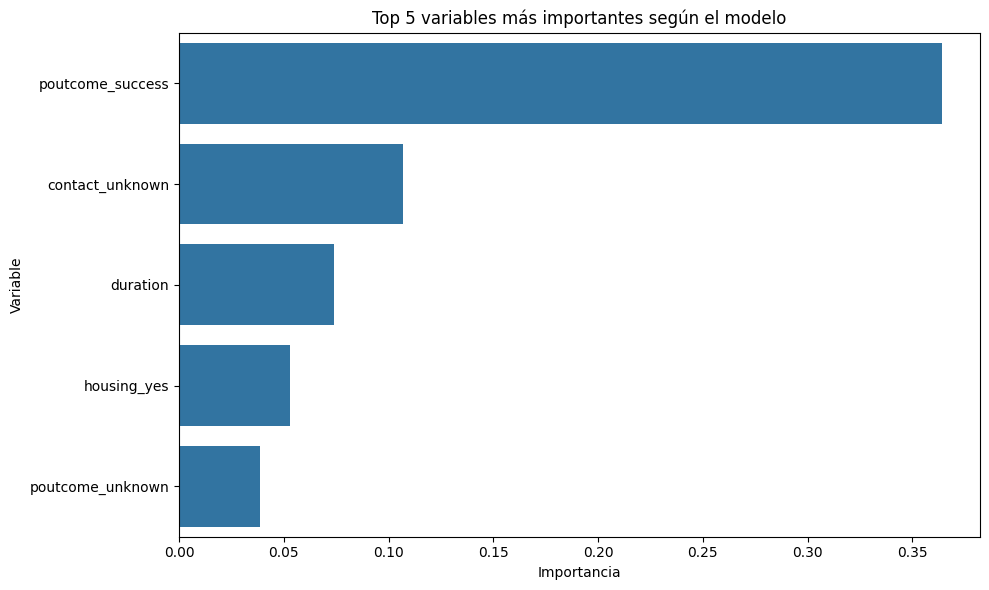

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extraemos la importancia de variables
importancia = pd.Series(mejor_modelo.feature_importances_, index=X.columns)

# Mostramos las 15 más importantes
importancia = importancia.sort_values(ascending=False).head(5)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=importancia, y=importancia.index)
plt.title("Top 5 variables más importantes según el modelo")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


Este gráfico te permitirá incluir en tu presentación:

Qué atributos afectan más la probabilidad de que un cliente se suscriba (y = yes)

Cómo interpretar posibles decisiones de negocio o reglas

🔷 Paso 5: Entrenamiento Final y Discusión de Resultados
Ahora que ya sabemos cuál es el mejor modelo, lo entrenaremos con el conjunto completo de datos, es decir, sin dividir en train/test. Esto permite aprovechar todos los registros disponibles para hacer predicciones reales o para implementarlo.

In [22]:
# Entrenar el modelo seleccionado con todos los datos
mejor_modelo.fit(X, y)


c:\Users\nichi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

✅ 5.3 Discusión de resultados
En tu presentación o memoria puedes incluir:

Modelo final: XGBoost (u otro según F1)

Motivo de selección: mejor equilibrio entre precisión y recall

Variables más importantes: vistas en el gráfico anterior

Acciones sugeridas:

Enfocarse en campañas con clientes con ciertas características (duration, contact, etc.)

Profundizar en las variables que más influyen en decisiones de suscripción